In [ ]:
%pip install pandas numpy seaborn matplotlib scikit-learn python-dotenv tensorflow llama-index

In [ ]:
import os
import warnings
import re
from collections import Counter

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from dotenv import load_dotenv

from llama_index.embeddings.openai import OpenAIEmbedding

from llama_index.core import (
    load_index_from_storage,
    StorageContext,
    Document,
    VectorStoreIndex,
    get_response_synthesizer
)

from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

import sys
import tensorflow as tf
from tensorflow.keras import preprocessing
sys.modules['keras.src.preprocessing'] = preprocessing

In [2]:
warnings.filterwarnings('ignore')

# Loading Data
Nb: Used parquet instead of csv to preserve data type

In [3]:
df = pd.read_parquet('../data/data_clustered_tsne.parquet.gzip')

Nb: Pre-loaded tsne-2d and tsne-3d to not waste time processing.

In [4]:
df.head()

,id,source,title,content,embedding,tsne-2d-1,tsne-2d-2,cluster,tsne-3d-1,tsne-3d-2,tsne-3d-3
0,0,tempo,Kapolri Instruksikan Proses Tegas Kasus Suap P...,"TEMPO.CO, Yogyakarta- Kapolri Jenderal Listyo ...","[0.006670293, -0.008296051, 0.018612592, -0.01...",29.873199,1.401189,0,18.658846,6.101427,3.910203
1,1,tempo,"Terdampak Banjir, Mentan Siap Bantu Petani di ...",INFO NASIONAL - Menteri Pertanian Syahrul Yasi...,"[-0.013915301, -0.018322684, 0.012273976, -0.0...",-46.414150,-4.596785,2,-20.185184,-2.371418,-8.996706
2,2,tempo,"Kementan Upayakan Perizinan Mudah, Cepat, dan ...",INFO NASIONAL - Kementerian Pertanian memastik...,"[0.015555209, -0.015595161, -0.001956054, -0.0...",-50.386646,-3.093976,1,-21.070637,-2.328195,-5.975774
3,3,tempo,Wapres Maruf Amin Dorong Pengusaha Sawit Perku...,INFO NASIONAL Para pengusaha yang tergabung d...,"[0.0035903626, -0.015759699, 0.008853396, -0.0...",-50.196079,-0.174417,1,-23.908243,0.352373,-4.074963
4,4,tempo,Menpan RB: Minat ASN Muda Pindah ke IKN Nusant...,"TEMPO.CO, Malang - Menteri Pendayagunaan Apara...","[-0.00013789257, -0.03197872, 0.012931213, 0.0...",-13.652273,16.243923,1,-3.523464,4.716335,0.848294


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32294 entries, 0 to 32293
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         32294 non-null  int64  
 1   source     32294 non-null  object 
 2   title      32294 non-null  object 
 3   content    32294 non-null  object 
 4   embedding  32294 non-null  object 
 5   tsne-2d-1  32294 non-null  float32
 6   tsne-2d-2  32294 non-null  float32
 7   cluster    32294 non-null  int32  
 8   tsne-3d-1  32294 non-null  float32
 9   tsne-3d-2  32294 non-null  float32
 10  tsne-3d-3  32294 non-null  float32
dtypes: float32(5), int32(1), int64(1), object(4)
memory usage: 2.0+ MB


In [6]:
load_dotenv('var.env')

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

embed_model = OpenAIEmbedding()

# Plotting

Convert to numpy

In [7]:
def convertEmbeddingStringToFloat(df, embedding_column):
     X = np.array(df[embedding_column].to_list(), dtype=np.float32)
     return X

Nb: Pre-converted embeddings to numpy to save loading time using convertEmbeddingStringToFloat

In [8]:
# X = convertEmbeddingStringToFloat(df, 'embedding')

In [9]:
X = np.load('../data/embeddings.npy')

Add t-sne columns for plotting

In [10]:
def reduceDimension(X, perplexity, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=123, perplexity=perplexity)
    tsne_results = tsne.fit_transform(X)
    return tsne_results

In [11]:
def convertTSNEtoDF(df, tsne_results):
    dimension = tsne_results.shape[1]
    for i in range(dimension):
        df[f'tsne-{dimension}d-{i+1}'] = tsne_results[:,i]
    return df

In [12]:
# tsne_results_2d = reduceDimension(X, 50)
# df = convertTSNEtoDF(df, tsne_results_2d)

# tsne_results_3d = reduceDimension(X, 50,  n_components=3)
# df = convertTSNEtoDF(df, tsne_results_3d)

Plotting

In [13]:
def plotTSNE2D(df, x_col, y_col, hue_col=None, highlight_points=None, title='t-SNE Plot Embedding'):
    fig, ax = plt.subplots(figsize=(8,6))

    if(hue_col=='cluster'):
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='hls')
    else:
        sns.scatterplot(data=df, x=x_col, y=y_col, palette='hls')

    if(highlight_points!=None):
        highlight_points = df.iloc[highlight_points]
        sns.scatterplot(
            data=highlight_points, 
            x=x_col,
            y=y_col,
            color='black',
            s=50,
            ax=ax
        )

    plt.title(title)
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')
    plt.axis('equal')
    plt.legend()
    plt.show()

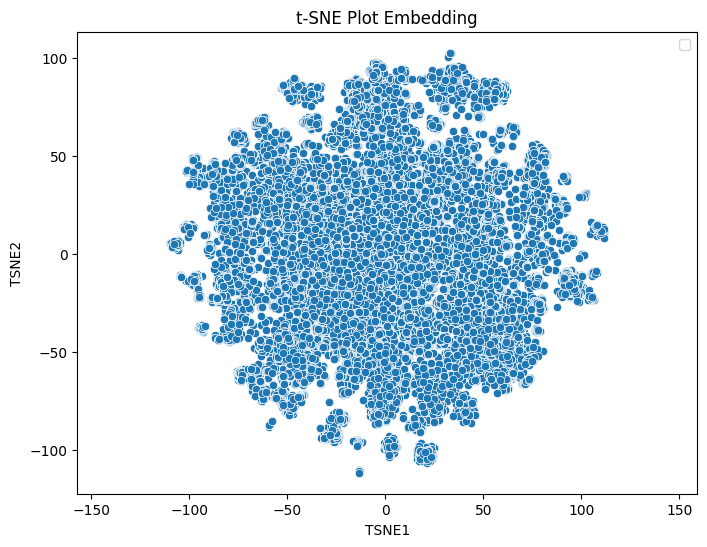

In [14]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2')

In [15]:
def plotTSNE3D(df, x_col, y_col, z_col, hue_col='id', highlight_points=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    cluster_colors = df[hue_col]
    sc = ax.scatter(df[x_col], df[y_col], df[z_col], c=cluster_colors, cmap='hsv')

    if(hue_col=='cluster'):
        colors = {0: 'blue', 1: 'orange', 2: 'green',3:'red', 4: 'purple', 5: 'brown'}
        cluster_colors = df[hue_col].map(colors)
        n_clusters = len(df[hue_col].unique())
        handles, labels = sc.legend_elements()
        ax.legend(handles, [f'Cluster {i}' for i in range(n_clusters)], title="Clusters")
    else:
        cluster_colors = df[hue_col]

    plt.colorbar(sc)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    plt.title('3D t-SNE Visualization')
    
    if(highlight_points!=None ):
        highlight_points = df.iloc[highlight_points]
        ax.scatter(
            highlight_points[x_col],
            highlight_points[y_col],
            highlight_points[z_col],
            color='black',
            s=100
        )
    
    plt.show()

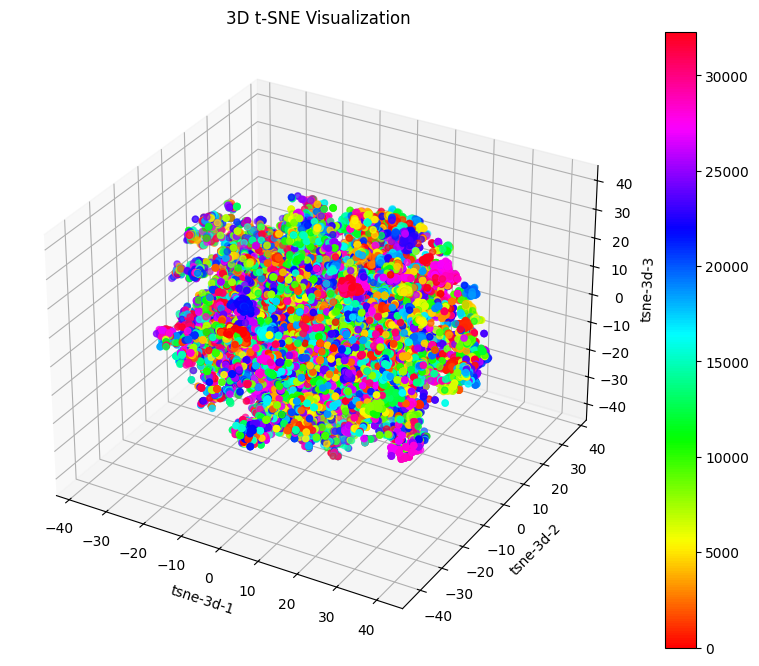

In [16]:
plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3')

# K-Means Clustering

Elbow Method: Optimal K seems to be 3 for the steepest decline

In [17]:
def elbowMethod(X, start, end):
    inertia_values = []
    k_range = range(start, end)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=123)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia_values, marker='o')
    plt.title('Optimal K')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_range)
    plt.grid(True)

    plt.ylim(0, max(inertia_values) + (0.2 * max(inertia_values)))

    plt.show()

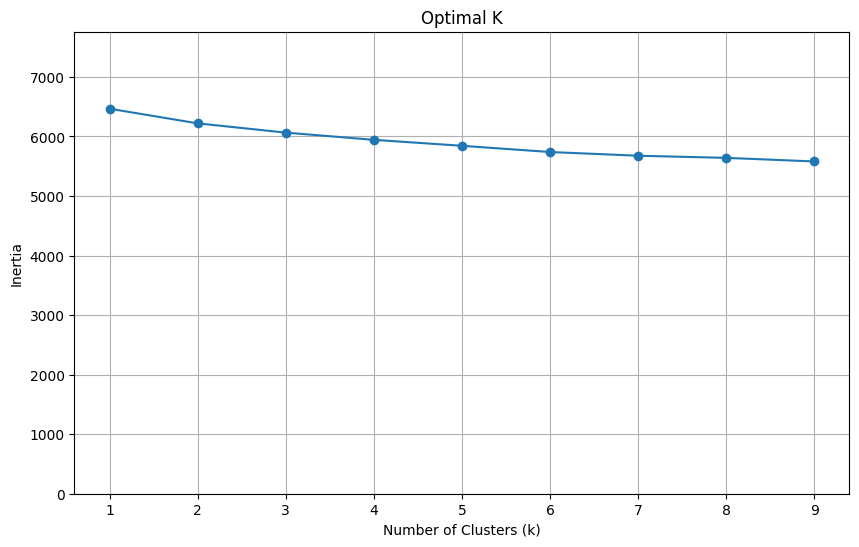

In [18]:
elbowMethod(X, 1, 10)

Fitting K-Means (used 6 cluster as per company request)

In [19]:
kmeans = KMeans(n_clusters=6, random_state=123).fit(X)
# df['cluster'] =  kmeans.labels_ # Already ran this and saved in parquet. 

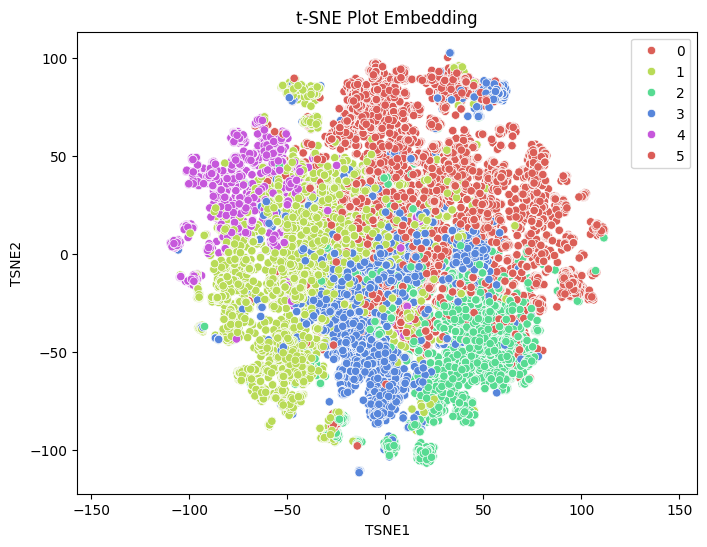

In [20]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster')

In [21]:
# # to make the plot interactive
# matplotlib widget

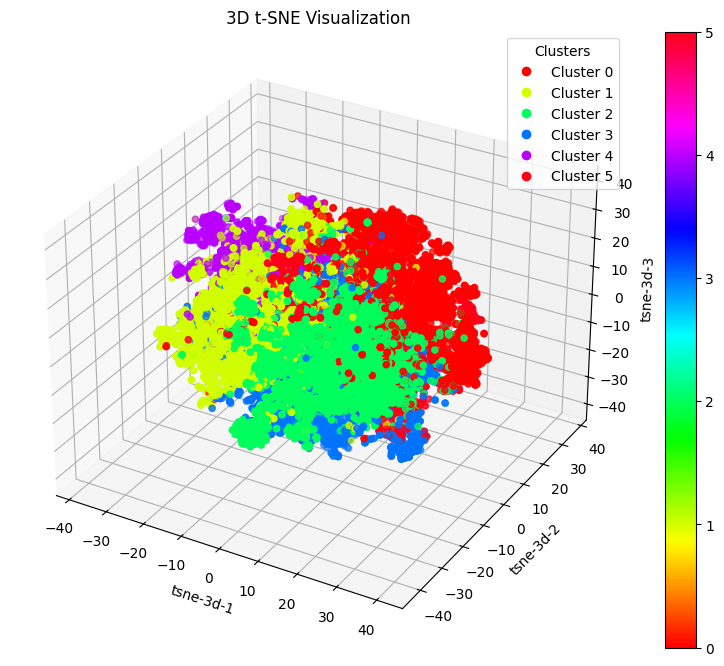

In [22]:
plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3', hue_col='cluster')

In [23]:
# # set it back so other graphs are not affected
# matplotlib inline

## Analyze Source Distribution

In [24]:
def countSource(df):
    source_count = df['source'].value_counts()
    return source_count

def countClusterSource(df):
    source_count = df.groupby(['cluster', 'source']).size().unstack(fill_value=0)
    return source_count

In [25]:
def plotSourceCount(df):
    source_count = countClusterSource(df)
    ax = source_count.plot(kind='bar', stacked=True, figsize=(12, 8))
    ax.set_title('Source Counts per Cluster', fontsize=16)
    ax.set_xlabel('Cluster', fontsize=14)
    ax.set_ylabel('Number of Articles', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Sources', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout() 
    plt.show()

def plotSourceCountEachCluster(df):
    sourceCountEachCluster = pd.crosstab(df['source'], df['cluster'])
    n_clusters = len(df['cluster'].unique())
    n_rows, n_cols = 2, 4
    n_sources = len(sourceCountEachCluster.index)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
    axes = axes.flatten() # flatten the 2D array of axes to 1D
    
    for i, source in enumerate(sourceCountEachCluster.index):
        cluster_percentages = (sourceCountEachCluster.loc[source] / sourceCountEachCluster.loc[source].sum()) * 100
        
        ax = axes[i]
        ax.pie(
            cluster_percentages, 
            labels=[f'Cluster {j}' for j in range(n_clusters)], 
            autopct='%1.1f%%', 
            startangle=140
        )
        ax.set_title(source)

    for j in range(n_sources, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plotClusterDistribution(df):
    source_count = countClusterSource(df)
    source_majority_table = source_count.idxmax(axis=1)
    source_majority_table = source_majority_table.rename('Majority Cluster')
    summary_table = pd.DataFrame({
        'Biggest Source': source_majority_table,
        'Total Count': source_count.sum(axis=1)
    })    
    return summary_table

In [26]:
countSource(df)

source
kumparan         8571
okezone          7066
cnbcindonesia    4506
suara            4004
tempo            3642
cnnindonesia     3491
jawapos          1014
Name: count, dtype: int64

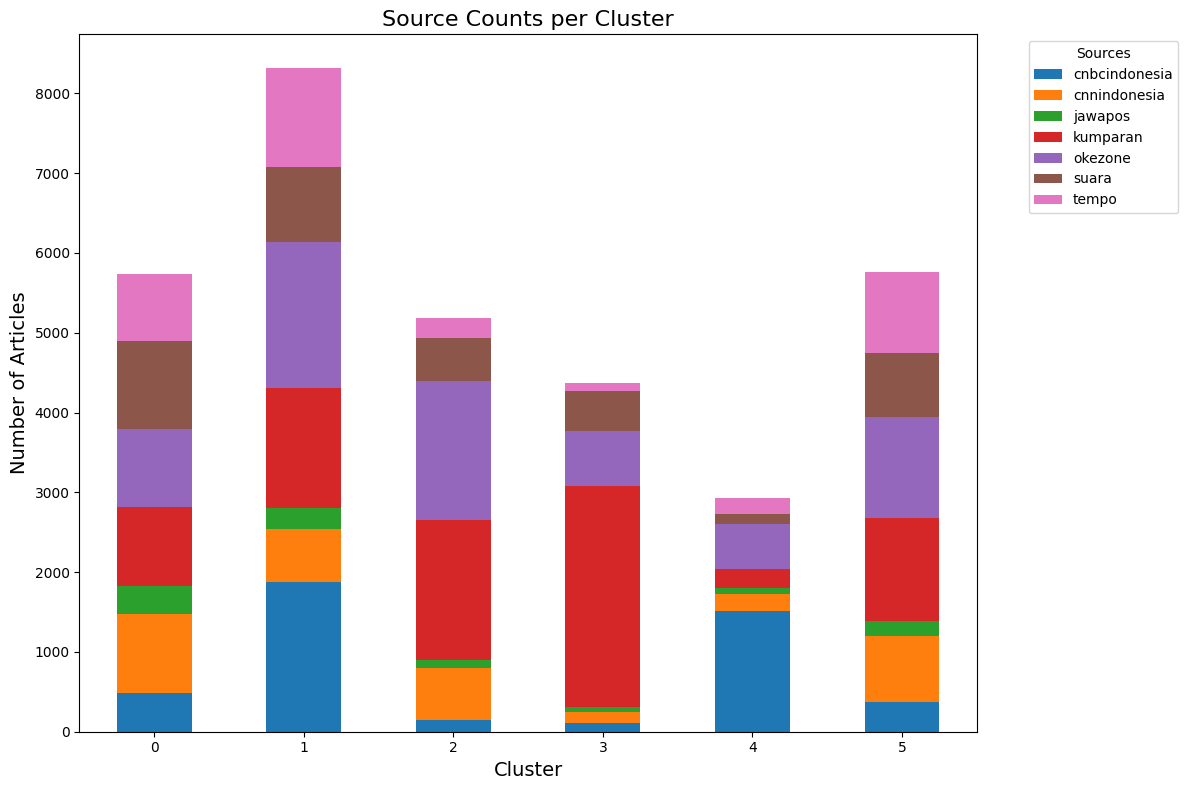

In [27]:
plotSourceCount(df)

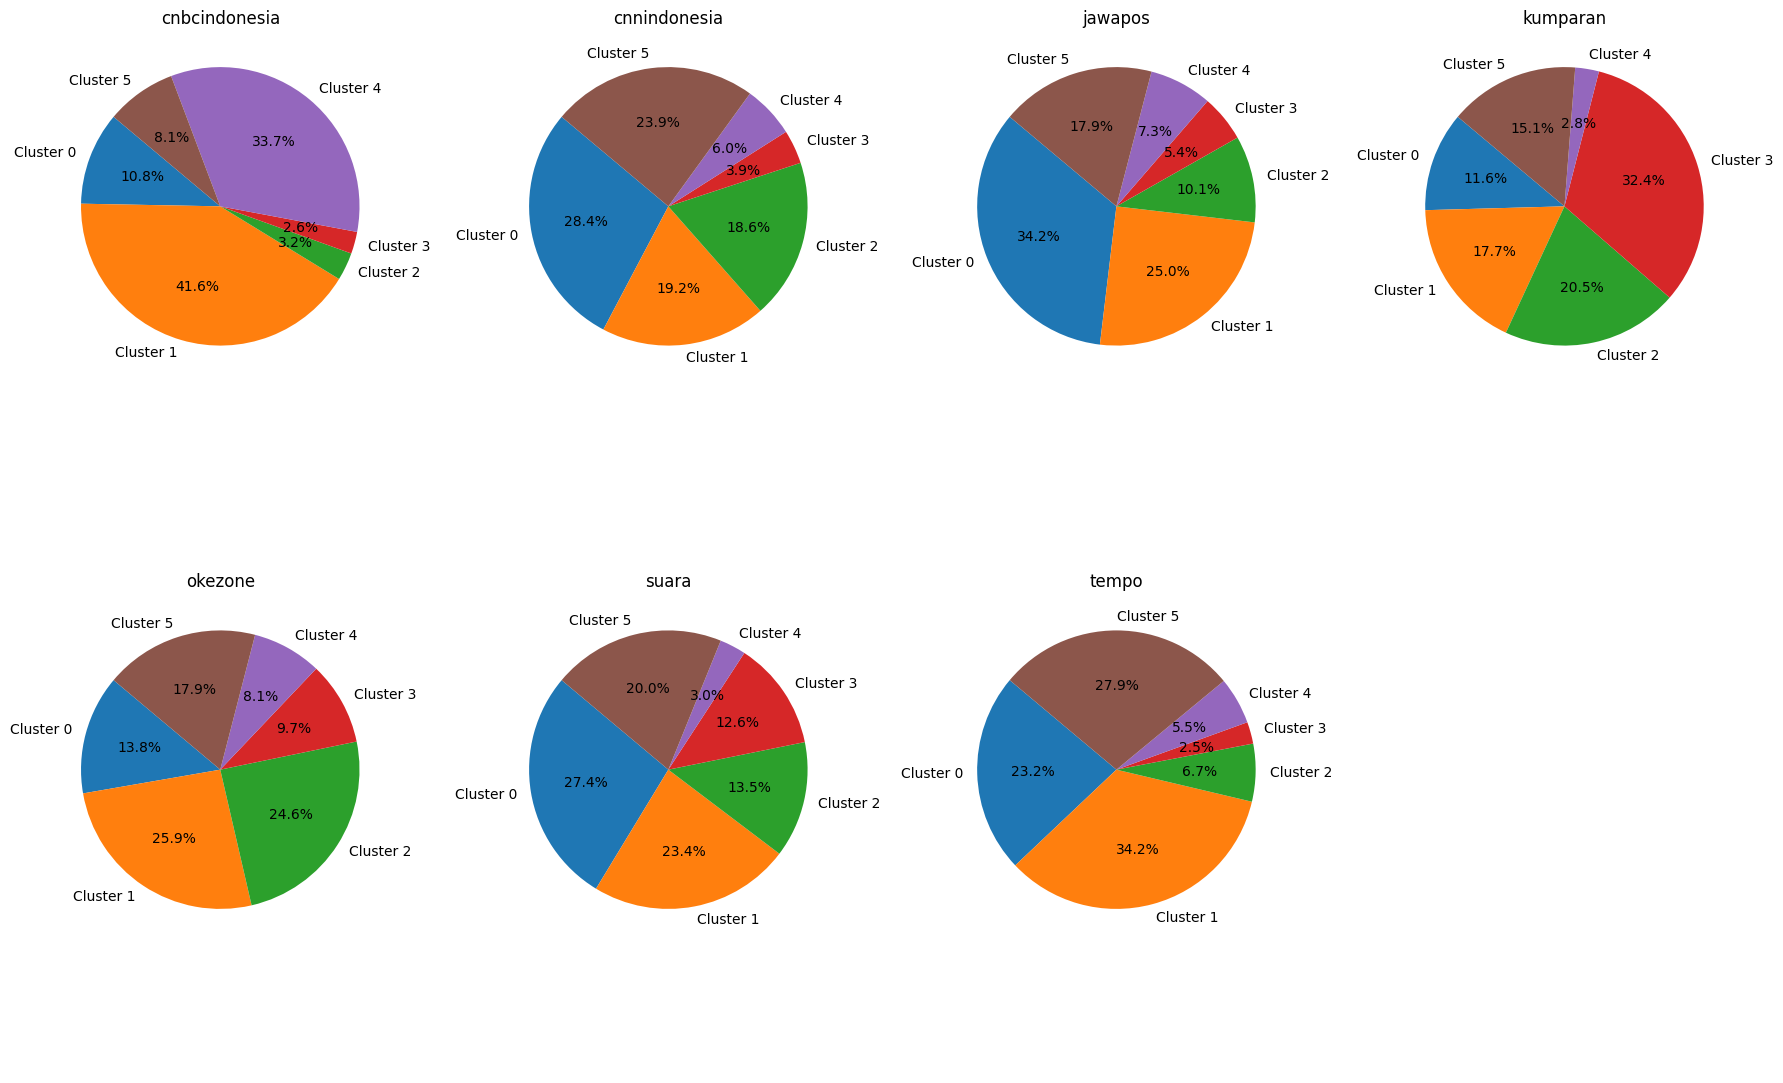

In [28]:
plotSourceCountEachCluster(df)

In [29]:
plotClusterDistribution(df)

,Biggest Source,Total Count
cluster,,
0,suara,5735
1,cnbcindonesia,8323
2,kumparan,5180
3,kumparan,4364
4,cnbcindonesia,2930
5,kumparan,5762


In [30]:
def createStopWordList(dir):
    stopWord_pd = pd.read_csv(dir, header=None)
    stopWordList = stopWord_pd[0].to_list()
    return stopWordList

def preprocessText(text, stopWordList):
    text = str(text)

    text = text.lower()

    text = re.sub(r'http\S+', '', text)

    text = re.sub(r'(@\w+|#\w+)', '', text)

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    text = re.sub(r'\n', ' ', text)

    text = re.sub(r'\s{2,}', ' ', text)
    
    words = text.split()

    words = [word for word in words if word not in stopWordList]

    return words

In [31]:
stopWordList = createStopWordList('../data/stopWordList.csv')

In [32]:
def wordCountEachCluster(df, stopWordList):
    clusterWordCount = {}
    for cluster in df['cluster'].unique():
        clusterArticles = df[df['cluster'] == cluster]['content']
        
        allWords = []
        for article in clusterArticles:
            allWords.extend(preprocessText(article, stopWordList))
        
        wordCount = Counter(allWords)
        clusterWordCount[cluster] = wordCount
        
    clusterWordCount = dict(sorted(clusterWordCount.items()))
    return clusterWordCount

def plotClusterWordCount(clusterWordCount, top_n=30):
    fig, axes = plt.subplots(nrows=len(clusterWordCount), figsize=(10, len(clusterWordCount)*6))

    for i, (cluster, word_counts) in enumerate(clusterWordCount.items()):
        top_words = word_counts.most_common(top_n)
        words, counts = zip(*top_words)
        
        ax = axes[i] if len(clusterWordCount) > 1 else axes
        ax.barh(words, counts)
        ax.set_title(f'Cluster {cluster} - Top {top_n} Words')
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Words')

    plt.tight_layout()
    plt.show()

In [33]:
clusterWordCount = wordCountEachCluster(df, stopWordList)

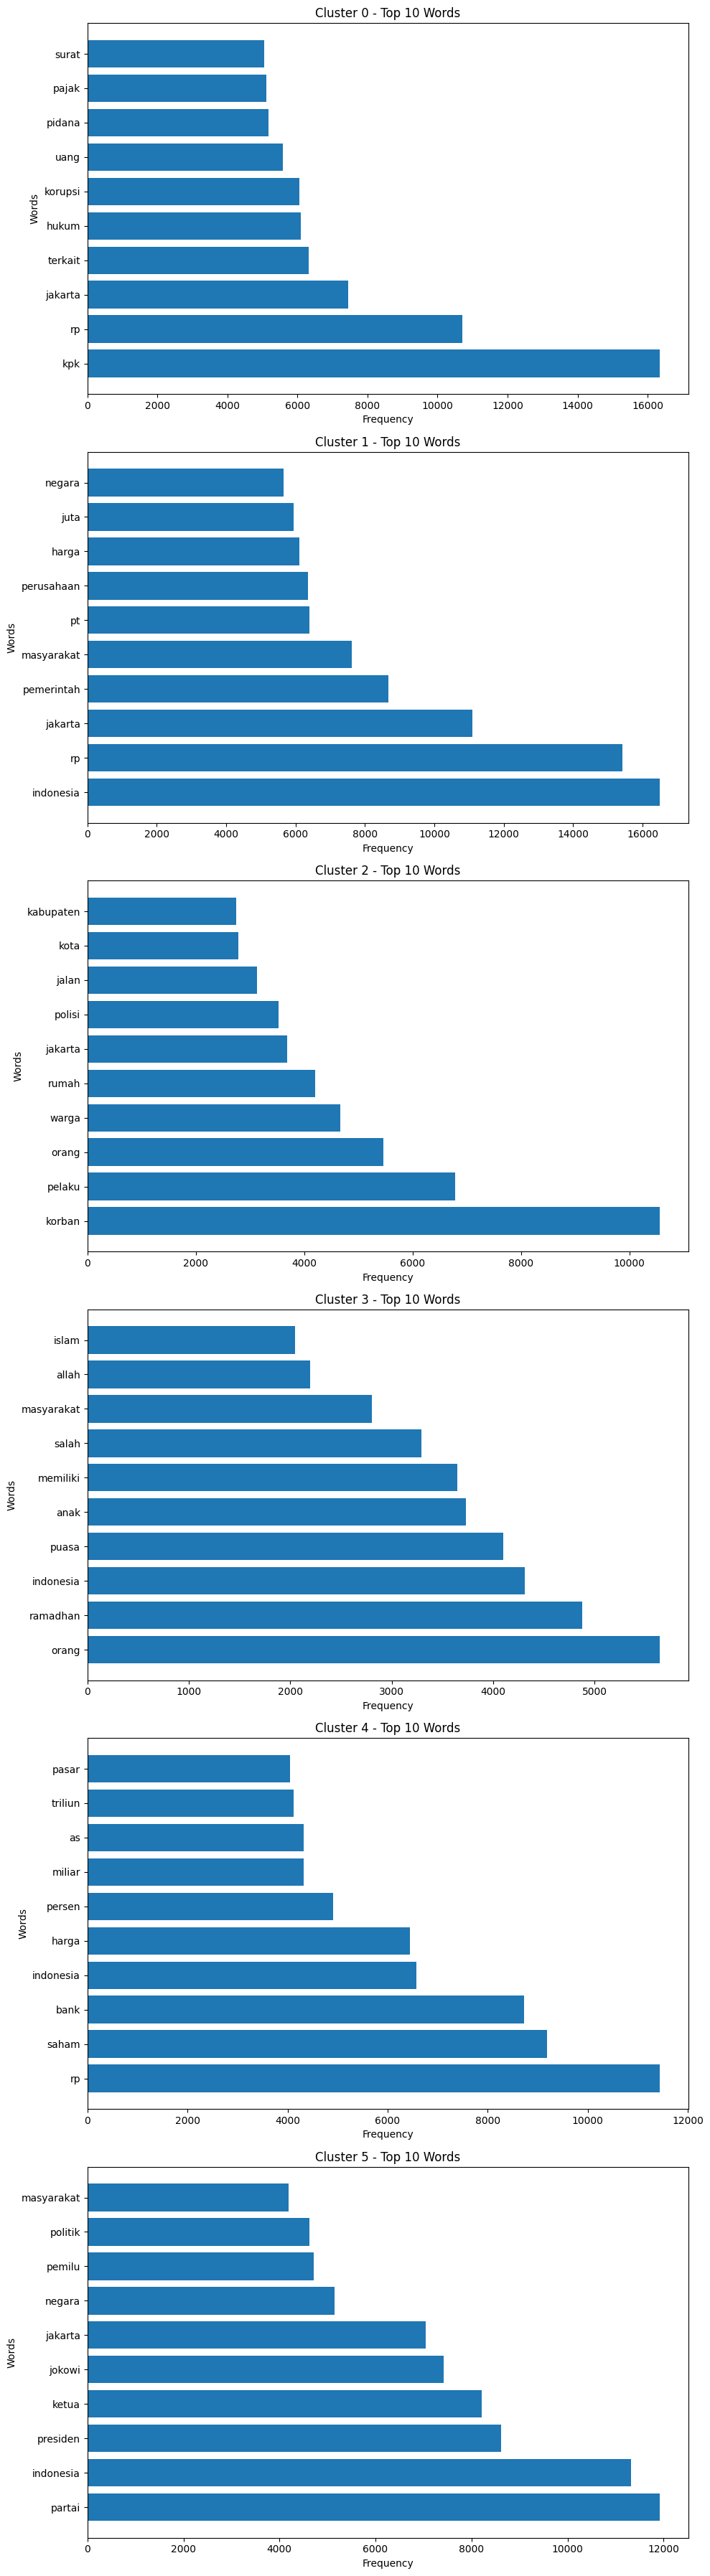

In [34]:
plotClusterWordCount(clusterWordCount, top_n=10)

# Research with Sample

In [35]:
def getNpEmbedding(embed_model, text):
    embedding = embed_model.get_text_embedding(text)
    return embedding, np.array(embedding, dtype=np.float32).reshape(1, -1)

def predictCluster(NpEmbedding, kmeans):
    predictedCluster = kmeans.predict(NpEmbedding)
    return predictedCluster

def getClusterCenter(kmeans):
    cluster_centers = kmeans.cluster_centers_
    return cluster_centers

def getDfofCluster(df, cluster):
    df_cluster = df[df['cluster'] == cluster]
    return df_cluster

In [36]:
def topWordsinCluster(clusterWordCount, cluster, top_n=100):
    topWordsCluster = clusterWordCount[cluster].most_common(top_n)
    topWordsCount = {word: count for word, count in topWordsCluster}

    for word, count in list(topWordsCount.items())[:10]:
        print(f"{word}: {count}")

    return topWordsCount

def topSimilarWords(text, pc, stopWordList, topWordsCount):
    textWords = preprocessText(text, stopWordList)

    textWordsCount = Counter(textWords)

    commonWordsCount = {word: textWordsCount[word] for word in textWords if word in topWordsCount}
    sortedCommonWordsCount = sorted(commonWordsCount.items(), key=lambda x: x[1], reverse=True)

    print(f"Predicted Cluster: {pc}")
    print(f"Common words in the new article that match top words in Cluster {pc}:")

    if sortedCommonWordsCount:
        for word, count in sortedCommonWordsCount:
            print(f"{word}: {count} / {topWordsCount[word]}")
    else:
        print("No common words found")

In [37]:
# sampleText = """
# Ibu Gregorius Ronald Tannur, Meirizka Widjaja telah tiba di Kejaksaan Agung (Kejagung RI) untuk dialkukan pemindahan penahanan setelah sebelumnya dilakukan di Surabaya setelah ditetapkan sebagai tersangka kasus dugaan suap demi vonis bebas Ronald Tannur dalam kasus tewasnya Dini Sera. Dia tiba di Kejagung dengan dibawa membawa mobil tahanan, Kamis (14/11/2024). Meirizka menggunakan rompi tahanan Kejaksaan Agung dengan tangan diborgol dan rambut terurai serta wajah tertutupi masker. Tidak satu kata pun yang disampaikan oleh Meirizka saat digelandang dari mobil menuju ke lift Gedung Kartika, Kejaksaan Agung. Meirizka ikut dipindahkan penahanan ke Jakarta setelah sebelumnya terlebih dahulu dilakukan oleh tiga hakim. Kepala Pusat Penerangan Hukum Kejagung Harli Siregar membenarkan adanya perpindahan penahanan terhadap Meirizka. Harli mengatakan pemindahan terhadap Meirizka dilakukan untuk mempermudah pemeriksaan terhadap Meirizka dalam perkara itu. Saat ini penyidik Kejagung terus melakukan pendalaman terkait aliran uang suap tersebut. "Untuk efektivitas penyidikan," ujar Harli. Sebelumnya, Kejaksaan Agung menetapkan Meirizka sebagai tersangka tersangka suap kepada para hakim melalui kuasa hukum Ronald Tannur, Lisa Rahmat. Meirizka sebelumnya memang memiliki kedekatan dengan Lisa sejak dibangku sekolah. Usai adanya persetujuan Lisa sebagai kuasa hukum dari terdakwa Ronald Tannur, Meirizka meminta Lisa untuk mengupayakan kasus hukum dari anaknya tersebut ke Pengadilan Negeri Surabaya. "Lisa menemui tersangka Zarof Ricar agar dapat memilih para hakim yang mengadili kasus anaknya tersebut," katanya. Dalam pertemuan antara Lisa dan para hakim yang akan mengurus kasus tersebut, Lisa mengajukan permintaan sejumlah uang yang akan diberikan kepada sejumlah hakim agar perkara Ronald Tannur dapat dibebaskan. Pada awal masa persidangan, Meirizka memberikan sejumlah uang senilai Rp1,5 miliar kepada Lisa sebagai biaya pengurusan kasus terpidana Ronald Tannur. Selanjutnya, Lisa juga menalangi uang biaya pengurusan kasus tersebut sebesar Rp2 miliar. “Totalnya Rp3,5 miliar. Terhadap uang tersebut menurut LR diberikan kepada majelis hakim yang mengadili perkara yang dimaksud,” ucap Qohar. Meirizka terbukti melanggar pasal 5 ayat 1 atau 6 ayat 1 huruf a juncto 18 UU No. 31 Tahun 1999 tentang tindak pidana korupsi sebagaimana diubah UU 20 Tahun 2001 perubahan 31 Tahun 1999 tentang tipikor juncto pasal 55 ayat 1 ke-1 KUHP.
# """
 
sample = df.sample()
sampleText = sample.iloc[0]['content']
df_sample = df.drop(sample.index) # Drop sample from df temporarily

In [38]:
sample[['source', 'title']]

,source,title
31191,cnnindonesia,Motor dan Truk VI B Dialihkan ke Pelabuhan Ciw...


In [39]:
sampleEmbedding, sampleNpEmbedding = getNpEmbedding(embed_model, sampleText)
pc = predictCluster(sampleNpEmbedding, kmeans)[0]
pc

1

In [40]:
topWordsCount = topWordsinCluster(clusterWordCount, pc, top_n=100)

indonesia: 16496
rp: 15418
jakarta: 11091
pemerintah: 8672
masyarakat: 7620
pt: 6407
perusahaan: 6350
harga: 6113
juta: 5937
negara: 5659


In [41]:
topSimilarWords(sampleText, pc, stopWordList, topWordsCount)

Predicted Cluster: 1
Common words in the new article that match top words in Cluster 1:
april: 5 / 4682
tiket: 4 / 2432
kendaraan: 3 / 3528
mudik: 3 / 5520
masyarakat: 3 / 7620
pemerintah: 2 / 8672
arus: 2 / 2222
lebaran: 2 / 4914
terkait: 2 / 3005
jalan: 2 / 4803
pt: 1 / 6407
indonesia: 1 / 16496
selasa: 1 / 2174
motor: 1 / 2485
senin: 1 / 2228
tol: 1 / 5123


# Finding Similar Articles
Using cosine similarity to find nearest n embeddings

In [42]:
def topSimilarArticles(textEmbedding, df, n, method, reverse=True):
    if(method=='cosine'): #True = closest, False = furthest
        similarities = cosine_similarity([textEmbedding],list(df['embedding']))[0]
    elif(method=='euclidean'): #False = closest, True = furthest
        similarities = euclidean_distances([textEmbedding], list(df['embedding']))[0]

    similarities = list(enumerate(similarities))
    topSimilar = sorted(similarities, key=lambda x: x[1], reverse=reverse)
    topSimilar = topSimilar[:n]

    return topSimilar

def recommendationsFromTopSimilar(df, topSimilar):
    article_idx = [i[0] for i in topSimilar]
    similarity_values = [i[1] for i in topSimilar]

    recommendations = df.iloc[article_idx].copy()
    recommendations['similarity'] = similarity_values
    return recommendations

In [43]:
sampleEmbedding = sample.iloc[0]['embedding']

In [44]:
topSimilar = topSimilarArticles(sampleEmbedding, df_sample, 10, 'cosine', reverse=True)

In [45]:
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)

In [46]:
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
28916,28916,cnnindonesia,Cek Rute Mudik 2023 ke Sumatra untuk Kendaraan...,1,0.962562
31442,31442,cnnindonesia,Kapolri Minta Rambu Lalu Lintas ke Pelabuhan C...,1,0.959778
31571,31571,okezone,Pelabuhan Ciwandan Disiapkan untuk Layani Pemu...,1,0.955629
30397,30397,cnbcindonesia,"Perhatian, Pemudik Motor Sumatra-Jawa Lewat Pe...",1,0.952713
20352,20352,okezone,Pemudik Motor Tujuan Sumatera Diseberangkan Me...,1,0.952534
31410,31410,suara,"Jangan Lupa, Pemudik Motor Bisa Naik Kapal Pen...",1,0.950678
29161,29161,okezone,"Jelang Mudik Lebaran, Kemenhub Matangkan Pengo...",1,0.949044
17311,17311,cnnindonesia,"Pemudik Motor Dilarang Lewat Pelabuhan Merak, ...",1,0.948875
30586,30586,cnnindonesia,"Arus Mudik ke Sumatra di Ciwandan, Kemhub Siap...",1,0.946659
28705,28705,kumparan,Tiket Kapal Ciwandan ke Lampung Sudah Tersedia...,1,0.946137


In [47]:
listofRecc = [sample.iloc[0]['id']]
for i in range(10):
    listofRecc.append(recommendations.iloc[i]['id'])

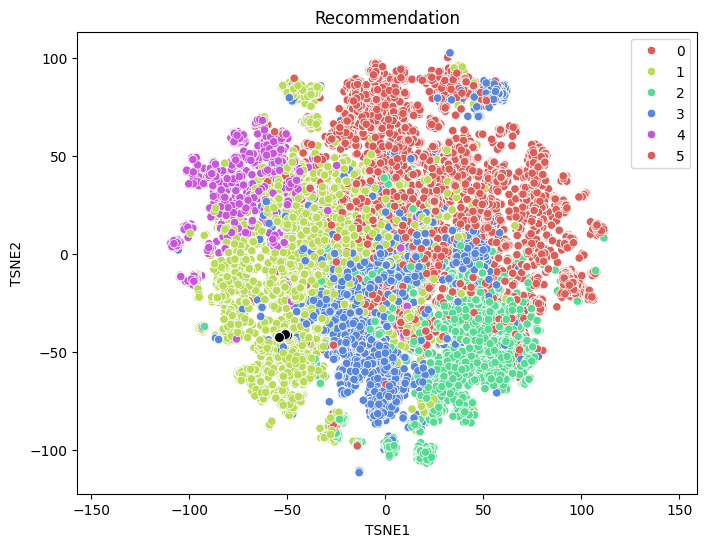

In [48]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=listofRecc, title='Recommendation')

# Average Correct Predictions

In [49]:
def countCorrectPredictions(df, totalSamples, increment, kmeans):
   correctPredictions = 0
   accuracyProgress = []

   for i in range(1, totalSamples + 1):
      sample = df.sample().values[0]
      sampleEmbedding = sample[4]
      npSampleEmbedding = np.array(sampleEmbedding, dtype=np.float32).reshape(1, -1)
      
      pc = predictCluster(npSampleEmbedding, kmeans)[0]
      similarities = cosine_similarity([sampleEmbedding], list(df['embedding']))
      similarities = list(enumerate(similarities[0]))
      similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:10]
      articleIndex = [i[0] for i in similarities]
      recommendations = df.iloc[articleIndex]
      
      recommendedCluster = recommendations['cluster'].values
      correctPredictions += np.sum(recommendedCluster == pc)
      
      if i % increment == 0:
         accuracy = correctPredictions / (i * 10)  
         accuracyProgress.append((i, accuracy))

   return accuracyProgress

def plotAccuracyProgress(accuracyProgress):
   x = [point[0] for point in accuracyProgress]
   y = [point[1] for point in accuracyProgress]

   plt.figure(figsize=(10, 6))
   plt.plot(x, y, marker='o', linestyle='-', color='b')
   plt.title('Accuracy in Increments of 100 Samples')
   plt.xlabel('Number of Samples Processed')
   plt.ylabel('Accuracy')
   plt.ylim(0, 1)
   plt.grid(True)
   plt.show()

In [50]:
accuracyProgress = countCorrectPredictions(df, 1000, 100, kmeans)

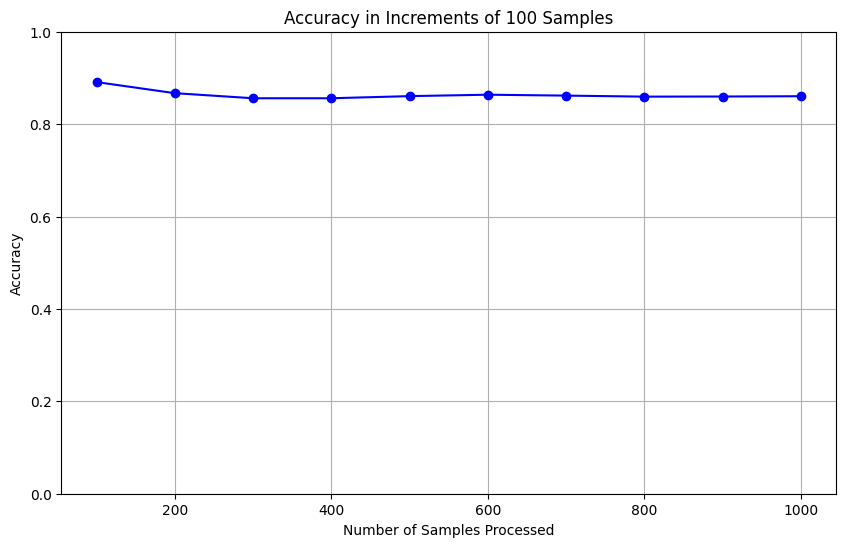

In [51]:
plotAccuracyProgress(accuracyProgress)

# Finding Dissimilar Articles
Cosine Similarity method (10 most dissimilar based on cosine)

In [52]:
topSimilar = topSimilarArticles(sampleEmbedding, df_sample, 10, 'cosine', reverse=False)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
12595,12595,kumparan,Pengertian Sosiologi secara Etimologis beserta...,3,0.713857
13828,13828,kumparan,"Karakteristik Perempuan Aries, Kompetitif dan ...",3,0.717881
18524,18524,kumparan,Makna Kata beserta Antonim Jahil Sesuai KBBI,3,0.718284
8074,8074,kumparan,Selena Gomez Jadi Perempuan Pertama yang Punya...,3,0.718628
27364,27364,kumparan,Apa Itu Family Issues dan Bagaimana Cara Menga...,3,0.723587
1276,1276,kumparan,Judul Lagu Kebangsaan Thailand beserta Sejarah...,3,0.724046
28021,28021,kumparan,Kenapa Anak Perempuan Bisa Protektif terhadap ...,3,0.724291
7147,7147,kumparan,Pengertian Unsur Nitrogen Lengkap dengan Fungs...,3,0.724432
14091,14091,kumparan,Pengertian Supervisi Pendidikan beserta Fungsinya,3,0.726093
4515,4515,kumparan,"Dalam Islam, Catatan Amal Buruk Ditulis oleh M...",3,0.726478


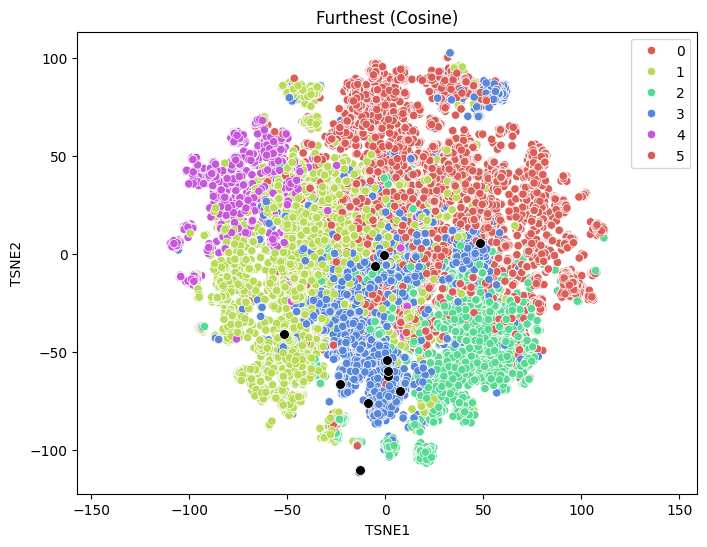

In [53]:
listofRecc = [sample.iloc[0]['id']]
for i in range(10):
    listofRecc.append(recommendations.iloc[i]['id'])

plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=listofRecc, title='Furthest (Cosine)')

Antipode Method (10 nearest to opposite of embedding)

In [54]:
antipode_embedding = -np.array(sampleEmbedding)
topSimilar = topSimilarArticles(antipode_embedding, df_sample, 10, 'cosine', reverse=True)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
12595,12595,kumparan,Pengertian Sosiologi secara Etimologis beserta...,3,-0.713857
13828,13828,kumparan,"Karakteristik Perempuan Aries, Kompetitif dan ...",3,-0.717881
18524,18524,kumparan,Makna Kata beserta Antonim Jahil Sesuai KBBI,3,-0.718284
8074,8074,kumparan,Selena Gomez Jadi Perempuan Pertama yang Punya...,3,-0.718628
27364,27364,kumparan,Apa Itu Family Issues dan Bagaimana Cara Menga...,3,-0.723587
1276,1276,kumparan,Judul Lagu Kebangsaan Thailand beserta Sejarah...,3,-0.724046
28021,28021,kumparan,Kenapa Anak Perempuan Bisa Protektif terhadap ...,3,-0.724291
7147,7147,kumparan,Pengertian Unsur Nitrogen Lengkap dengan Fungs...,3,-0.724432
14091,14091,kumparan,Pengertian Supervisi Pendidikan beserta Fungsinya,3,-0.726093
4515,4515,kumparan,"Dalam Islam, Catatan Amal Buruk Ditulis oleh M...",3,-0.726478


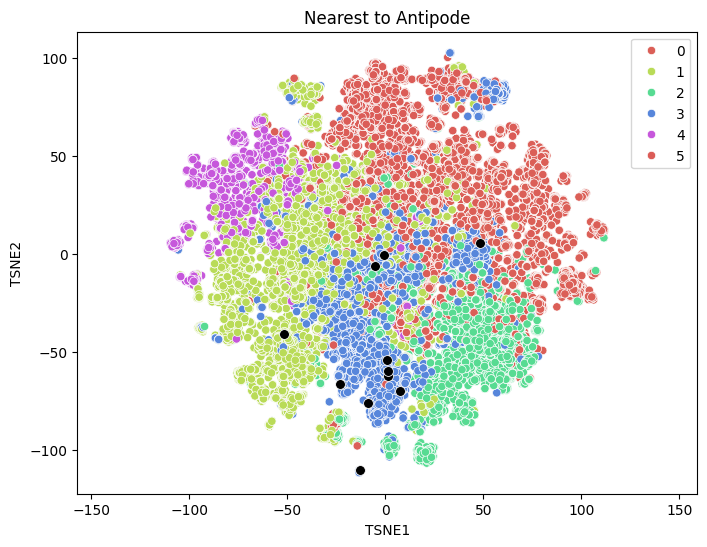

In [55]:
list_of_recc = [sample.iloc[0]['id']]
for i in range(10):
    list_of_recc.append(recommendations.iloc[i]['id'])
    
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc, title='Nearest to Antipode')

Euclidean Method (Finding 10 furthest distance)

In [56]:
topSimilar = topSimilarArticles(antipode_embedding, df_sample, 10, 'euclidean', reverse=False)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
12595,12595,kumparan,Pengertian Sosiologi secara Etimologis beserta...,3,1.851409
13828,13828,kumparan,"Karakteristik Perempuan Aries, Kompetitif dan ...",3,1.853581
18524,18524,kumparan,Makna Kata beserta Antonim Jahil Sesuai KBBI,3,1.853798
8074,8074,kumparan,Selena Gomez Jadi Perempuan Pertama yang Punya...,3,1.853984
27364,27364,kumparan,Apa Itu Family Issues dan Bagaimana Cara Menga...,3,1.856656
1276,1276,kumparan,Judul Lagu Kebangsaan Thailand beserta Sejarah...,3,1.856904
28021,28021,kumparan,Kenapa Anak Perempuan Bisa Protektif terhadap ...,3,1.857036
7147,7147,kumparan,Pengertian Unsur Nitrogen Lengkap dengan Fungs...,3,1.857112
14091,14091,kumparan,Pengertian Supervisi Pendidikan beserta Fungsinya,3,1.858006
4515,4515,kumparan,"Dalam Islam, Catatan Amal Buruk Ditulis oleh M...",3,1.858213


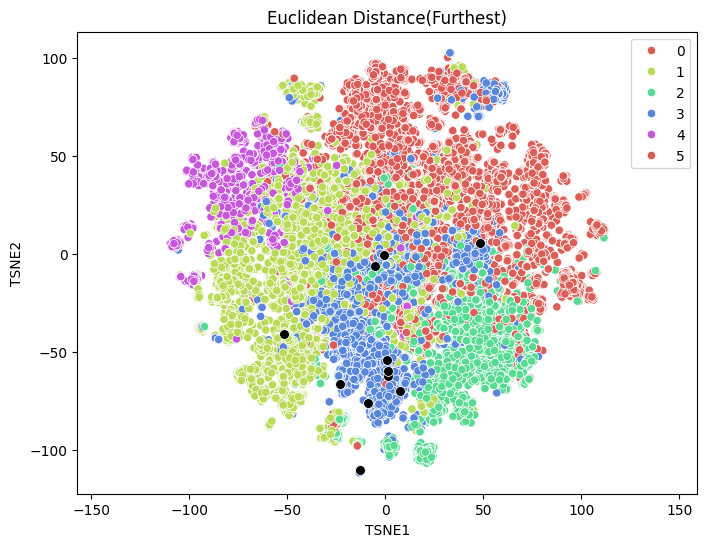

In [57]:
list_of_recc = [sample.iloc[0]['id']]
for i in range(10):
    list_of_recc.append(recommendations.iloc[i]['id'])
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc, title='Euclidean Distance(Furthest)')

# Two Most Dissimilar News Articles
- To check their position in graph

In [58]:
def MostDissimilarCosine(df):
    similarity_matrix = cosine_similarity(list(df['embedding']), list(df['embedding']))
    np.fill_diagonal(similarity_matrix, np.inf)
    min_similarity = np.min(similarity_matrix)
    row, col = np.unravel_index(np.argmin(similarity_matrix), similarity_matrix.shape)
    return row, col, min_similarity

In [59]:
def MostDissimilarEuclidean(df):
    distance_matrix = euclidean_distances(list(df['embedding']), list(df['embedding']))
    np.fill_diagonal(distance_matrix, -np.inf)
    min_similarity = np.max(distance_matrix)
    row, col = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    return row, col, min_similarity

Cosine similarity method

In [60]:
row, col, min_similarity = MostDissimilarCosine(df)
print(f"Most Dissimilar Pair of Articles by Cosine Similarity: {row}, {col}")
print(f"Cosine similarity: {min_similarity}")

print("Text 1:", df.iloc[row]['title'])  
print("Text 2:", df.iloc[col]['title'])

Most Dissimilar Pair of Articles by Cosine Similarity: 12907, 21469
Cosine similarity: 0.6644615229792243
Text 1: 3 Kebaikan yang Diberikan Pohon Apel
Text 2: Hasil Kualifikasi & Sprint Race MotoGP Argentina 2023


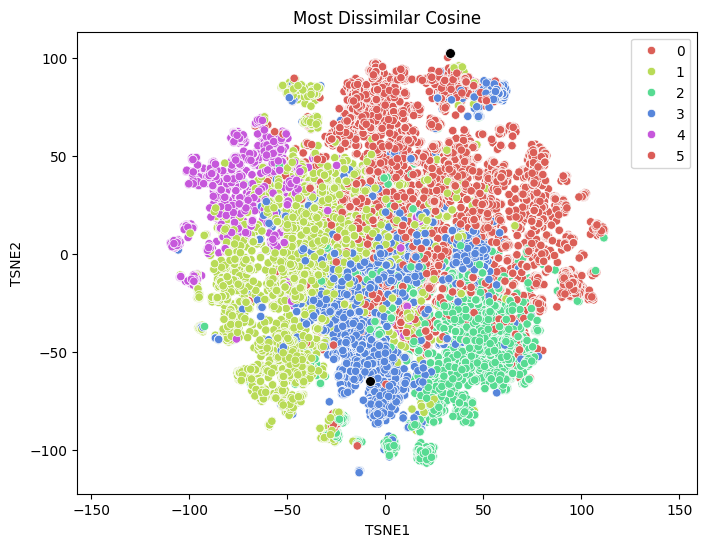

In [61]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=[row, col], title='Most Dissimilar Cosine')

In [62]:
# %matplotlib widget

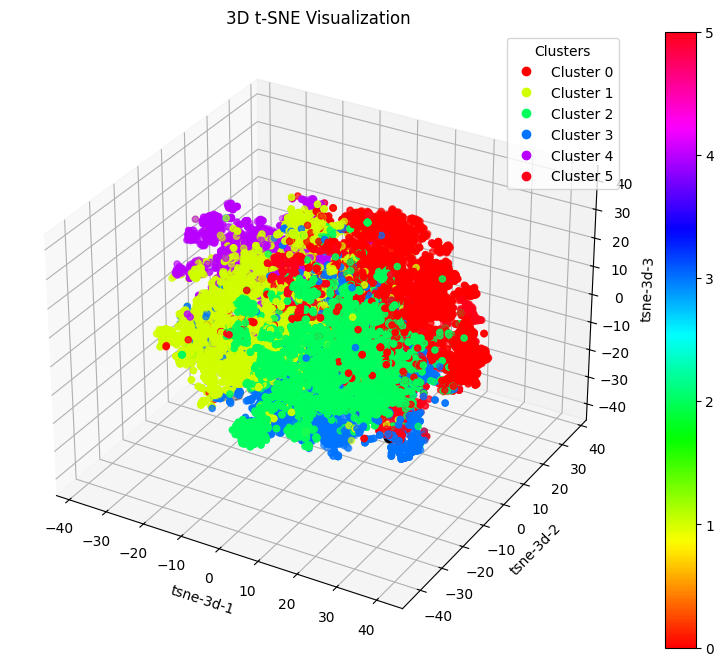

In [63]:
plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3', hue_col='cluster', highlight_points=[row, col])

In [64]:
# %matplotlib inline

Euclidean Method (Results show the same)

In [65]:
row, col, min_similarity = MostDissimilarEuclidean(df)

In [66]:
print(f"Most Dissimilar Pair of Articles by Euclidean Distance: {row}, {col}")
print(f"Euclidean Distance: {min_similarity}")

print("Text 1:", df.iloc[row]['title'])  
print("Text 2:", df.iloc[col]['title'])

Most Dissimilar Pair of Articles by Euclidean Distance: 12907, 21469
Euclidean Distance: 0.8191928856235674
Text 1: 3 Kebaikan yang Diberikan Pohon Apel
Text 2: Hasil Kualifikasi & Sprint Race MotoGP Argentina 2023


# Run the sample and 10 recommendations to model

In [67]:
sample = df.sample()
sampleText = sample.iloc[0]['content']
df_sample = df.drop(sample.index)
sampleEmbedding = sample.iloc[0]['embedding']
topSimilar = topSimilarArticles(sampleEmbedding, df_sample, 10, 'cosine', reverse=True)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
4212,4212,kumparan,"IHSG Berakhir Merah, Ditutup Turun 0,21 Persen...",4,0.995578
5489,5489,kumparan,"IHSG Betah di Zona Merah, Ditutup Turun 0,94 P...",4,0.993536
2361,2361,kumparan,"IHSG Sesi I Ditutup Merah, Turun 1,54 Persen k...",4,0.989775
30029,30029,kumparan,"IHSG Seharian Merah, Ditutup Turun 0,32 Persen...",4,0.989151
29842,29842,kumparan,"IHSG Sesi I Ditutup Merah, Turun 0,66 Persen k...",4,0.986955
16963,16963,kumparan,"IHSG Seharian di Zona Merah, Turun 0,79 Persen",4,0.985024
26607,26607,kumparan,"IHSG Ditutup Merah, Turun 0,39 Persen",4,0.984296
23845,23845,kumparan,"IHSG Sesi I Merah, Turun 0,38 Persen",4,0.983665
25256,25256,kumparan,"IHSG Ditutup Merah 0,20 Persen, Rupiah 14.932 ...",4,0.983607
22672,22672,kumparan,"244 Saham Hijau, IHSG Ditutup Naik 0,32 Persen",4,0.981921


In [68]:
model = load_model('../model/hoax_detection_A3.h5')
with open('../model/tokenizer_A3.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [69]:
allArticles = [sampleText] + list(recommendations['content'])

allSequences = tokenizer.texts_to_sequences(allArticles)
paddedAllSequences = pad_sequences(allSequences, maxlen=100, padding='post', truncating='post')

predictedProbabilities = model.predict(paddedAllSequences)
predictedClasses = (predictedProbabilities > 0.5).astype(int)
predictions = ["Fake" if pred == 1 else "Real" for pred in predictedClasses]
recommendations['newsRealorFake'] = predictions[1:]
print(recommendations[['source', 'title', 'newsRealorFake']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
         source                                              title  \
4212   kumparan  IHSG Berakhir Merah, Ditutup Turun 0,21 Persen...   
5489   kumparan  IHSG Betah di Zona Merah, Ditutup Turun 0,94 P...   
2361   kumparan  IHSG Sesi I Ditutup Merah, Turun 1,54 Persen k...   
30029  kumparan  IHSG Seharian Merah, Ditutup Turun 0,32 Persen...   
29842  kumparan  IHSG Sesi I Ditutup Merah, Turun 0,66 Persen k...   
16963  kumparan     IHSG Seharian di Zona Merah, Turun 0,79 Persen   
26607  kumparan              IHSG Ditutup Merah, Turun 0,39 Persen   
23845  kumparan               IHSG Sesi I Merah, Turun 0,38 Persen   
25256  kumparan  IHSG Ditutup Merah 0,20 Persen, Rupiah 14.932 ...   
22672  kumparan     244 Saham Hijau, IHSG Ditutup Naik 0,32 Persen   

      newsRealorFake  
4212            Real  
5489            Real  
2361            Real  
30029           Real  
29842           Real  
16963           Real  
26607           Real  
23845 

In [70]:
with open('../model/bias_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

interpreter = tf.lite.Interpreter(model_path='../model/bias_detection_lstm.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [71]:
newSequences = tokenizer.texts_to_sequences(allArticles)
maxLen = 30
new_padded = pad_sequences(newSequences, maxlen=maxLen)

new_padded = new_padded.astype('float32')

results = []

for i, article_padded in enumerate(new_padded):
    interpreter.set_tensor(input_details[0]['index'], article_padded.reshape(1, -1))
    interpreter.invoke()
    
    predictionsTfLite = interpreter.get_tensor(output_details[0]['index'])
    
    predictedLabelsTfLite = 1 if predictionsTfLite[0] > 0.5 else 0
    textLabel = "Bias" if predictedLabelsTfLite == 1 else "Netral"
    
    results.append(textLabel)

recommendations['isBiased'] = results[1:] 

print(recommendations[['source', 'title', 'newsRealorFake', 'isBiased']])

         source                                              title  \
4212   kumparan  IHSG Berakhir Merah, Ditutup Turun 0,21 Persen...   
5489   kumparan  IHSG Betah di Zona Merah, Ditutup Turun 0,94 P...   
2361   kumparan  IHSG Sesi I Ditutup Merah, Turun 1,54 Persen k...   
30029  kumparan  IHSG Seharian Merah, Ditutup Turun 0,32 Persen...   
29842  kumparan  IHSG Sesi I Ditutup Merah, Turun 0,66 Persen k...   
16963  kumparan     IHSG Seharian di Zona Merah, Turun 0,79 Persen   
26607  kumparan              IHSG Ditutup Merah, Turun 0,39 Persen   
23845  kumparan               IHSG Sesi I Merah, Turun 0,38 Persen   
25256  kumparan  IHSG Ditutup Merah 0,20 Persen, Rupiah 14.932 ...   
22672  kumparan     244 Saham Hijau, IHSG Ditutup Naik 0,32 Persen   

      newsRealorFake isBiased  
4212            Real     Bias  
5489            Real     Bias  
2361            Real     Bias  
30029           Real     Bias  
29842           Real     Bias  
16963           Real     Bias  
26607

In [72]:
documents = []
for index, row in recommendations.iterrows():
    document = Document(
    text=row['content'],
    doc_id=str(row['id']),
    metadata={
        'title': row['title'],
        'source': row['source'],
        'isBiased': row['isBiased'],
        'newsRealorFake': row['newsRealorFake']
    },
    embedding=(row['embedding'])
    )
    documents.append(document)

In [73]:
def createVectorIndex(documents):
    index = VectorStoreIndex.from_documents(documents)
    index.storage_context.persist(persist_dir="../storage")

def loadVectorIndex():
    storage_context = StorageContext.from_defaults(persist_dir="../storage")
    index = load_index_from_storage(storage_context)
    return index

In [74]:
createVectorIndex(documents)

In [75]:
index = loadVectorIndex()

In [76]:
query_str = (
    "News Article Title: " + sample.iloc[0]['title'] + "\n"
    "News Article Content: " + sampleText + "\n"
    "News Article Source: " + sample.iloc[0]['source'] + "\n"
    "News Article Bias (Biased/Netral): " + recommendations.iloc[0]['isBiased'] + "\n"
    "News Article is detected to be: " + recommendations.iloc[0]['newsRealorFake']
)

print(query_str)

News Article Title: IHSG Ditutup Anjlok 2,14 Persen Imbas Silicon Valley Bank Kolaps
News Article Content: Indeks Harga Saham Gabungan ( ) berakhir di zona merah pada penutupan perdagangan saham sore ini, Selasa (14/3). ditutup anjlok 145,141 poin (2,14 persen) ke posisi 6.641,814. Sedangkan indeks LQ45 ditutup melemah 22,462 poin (2,39 persen) ke 917,376. Sebanyak 101 saham naik, 478 saham turun, dan 146 saham stagnan. Frekuensi saham ditransaksikan sebanyak 1.318.084 juta kali dengan total volume perdagangan sebanyak 19,480 miliar saham senilai Rp 11,451 triliun. Saham-saham pendorong top losers sore ini di antaranya: Saratoga Investama Sedaya (SRTG) turun 150 poin atau 6,98 persen ke 2.000; Bintang Samudera Mandiri Lines (BSML) turun 22 poin atau 6,96 persen ke 294; Malacca Trust Wuwungan Insurance (MTWI) turun 8 poin atau 6,96 persen ke 107. Mengutip data Bloomberg, nilai tukar rupiah sore ini melemah 8 poin (0,05 persen) di Rp 15.385 terhadap dolar AS. Indeks Nikkei 225 di Jepang 

In [77]:
instruction = """
You are a news article analyzer capable of determining political bias by analyzing what is being highlighted. Please provide an explanation of why you chose a particular side, citing specific examples from the text that demonstrate its alignment. Do not speak in first person.

Assess the article using the following bias ratings:
Neutral: The article presents balanced coverage with no clear lean toward any political side, offering both governmental and opposition views fairly or taking no sides. It avoids strong language or overt opinions, focusing on facts and events without significant framing or bias.
Progressive: The article tends to highlight progressive social, economic, or political reforms. It may support the expansion of civil rights, greater equality, or address sensitive issues like minority rights or environmental concerns. A progressive stance is often more critical of the status quo and may push for change.
Conservative: The article tends to highlight traditional values, maintaining or returning to the status quo. It often aligns with religious or nationalistic views and may criticize progressive movements or policies that challenge these traditional values.
Critical: The article critiques the government. While it may be negative or adversarial, it can also be constructive in its criticism, highlighting flaws, mismanagement, or policies that need reform. Critical content does not shy away from highlighting issues or injustices.

Expected Answer:
Bias Rating: Rate the article and explain your choice of Bias (if it is biased as specified) with brief examples from the text.
Hoax Rating: Compare the article with the information you have. Explain which part of the given article is different if any.
Key Indicators of Bias: Explain if there are any opinionated content, selective facts, extreme language, persuasive tactics, unsupported claims, anonymity, entertainment-based content, or disguised sales pitches.
Conclusion: Summarize findings of bias and hoax, mentioning if there were any nuances or mixed signals.
"""

In [78]:
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=10,
)

response_synthesizer = get_response_synthesizer()

class CustomRetrieverQueryEngine(RetrieverQueryEngine):
    def query(self, query_text: str):
        retrieverResults = self.retriever.retrieve(query_text)
        return super().query(query_text)

query_engine = CustomRetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.5)],
)

In [79]:
response = query_engine.query(instruction + query_str)
print(response)

Bias Rating: Critical
Explanation: The article demonstrates a critical bias by highlighting the significant drop in the stock market and attributing it to the collapse of Silicon Valley Bank. It critiques the government's handling of the situation and emphasizes the negative impact on various stocks, providing specific examples of top losers. The language used is critical and highlights flaws in the financial system, suggesting a need for reform.

Hoax Rating: The given article is real and matches the information provided.

Key Indicators of Bias: The article contains opinionated content by attributing the stock market decline to a specific event, using critical language to describe the situation, and focusing on the negative aspects without balancing perspectives. It also includes selective facts by highlighting only the top losers and emphasizing the negative impact.

Conclusion: The article exhibits a critical bias by focusing on the negative implications of the stock market decline